# Problem 1

Import necessary modules, parameters and data.

In [40]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [41]:
alpha = 0.1
K = 1000
B = 128
N = 512

def f_true(x) :
    return (x-2) * np.cos(x*4)

In [42]:
torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1),), batch_size=B)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

As in example code, we use 3-layer FC neural network with sigmoid activation.
Note that, since our result has no restriction (that is, result can becomes any real number), there is no activation sigmoid after layer 3.

In [43]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1,64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,1)
        
        for layer in [self.layer1, self.layer2, self.layer3]:
            layer.weight.data = torch.normal(0,1,size=layer.weight.shape)
            layer.bias.data = torch.full(layer.bias.shape, 0.03)
            
    def forward(self, x):
        out = torch.sigmoid(self.layer1(x))
        out = torch.sigmoid(self.layer2(out))
        out = self.layer3(out)
        return out

mlp = MLP()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(params=mlp.parameters(), lr=alpha)

Now we repeat learning process K times, and each learning process constitutes of propagation-backpropagation of all batch.
Thus we iterate propagation-backpropagation step K*(N/B) = 1000*(512/128) = 4000 times.

In [44]:
block_num = N//B

for ep in range(K):
    for x,y in train_dataloader:
        y_batch = mlp(x)
        loss = loss_fn(y_batch, y)/2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

To check whether our layer learns well, we draw a plot and compare to the true function. The result is following.

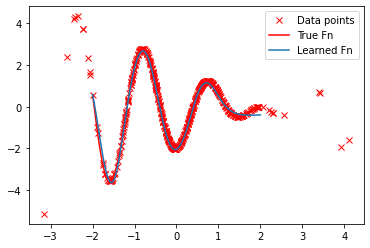

In [45]:
with torch.no_grad():
    xx = torch.linspace(-2,2,1024).unsqueeze(1)
    plt.plot(X_train, y_train, 'rx',label='Data points')
    plt.plot(xx, f_true(xx), 'r',label='True Fn')
    plt.plot(xx, mlp(xx), label='Learned Fn')
plt.legend()
plt.show()

As you can see, our network works well.